In [95]:
from pandas import read_csv
import sys
from google.colab import drive
import pandas as pd
import numpy as np
from numpy import array, argmax
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot
import itertools
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from sklearn import svm
import pickle

# Mount drive (mounts to much higher folder than "My Drive")
drive.mount("/content/drive/")
# This path extension only works when you have our "/Explainable AI Group Work/" folder as a shortcut in "MyDrive"
path = "drive/MyDrive/Explainable AI Group Work/MOOC Model/src-Vignesh-Muthukumar"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [96]:
dataset = read_csv(path + "/data/cs_mitx.csv", encoding="ISO-8859-1")
forum = read_csv(path+"/data/course_posts.csv")
df = dataset[['viewed','Completed_or_Not','gender', 'grade', 'nevents', 'ndays_act', 'nplay_video', 'nchapters' ,'age']]
# dataset = read_csv(path + "/data/cs_mitx_composite.csv", encoding="ISO-8859-1")

In [97]:
""" DO WE CHANGE THIS / OUTSOURCE TO ANOTHER FILE? """
#One-hot encoding for converting gender m/f to 0/1
data = df[['gender']]
values = array(data).ravel()
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
integer_encoded = integer_encoded.reshape((integer_encoded.shape[0], 1))
df[['gender']]=integer_encoded

<ipython-input-97-fc5079c51b19>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['gender']]=integer_encoded


In [98]:
df1=forum[['votes','num_words']]
df1=df1[0:59279]
df=pd.concat([df,df1], axis=1)

In [99]:
df = df.dropna(axis="index") # Drop all missing values
X=df.iloc[:,[0,2,3,4,5,6,7,8,9,10]]
y=df.iloc[:,1]

In [100]:
y.unique()
X=X.values
type(X)

numpy.ndarray

In [101]:
all_classes=['Not Completed','Completed']

In [102]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [103]:
# [viewed,	gender,	grade	nevents, ndays_act,	nplay_video,	nchapters,	age,	votes,	num_words]
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.20)

In [104]:
dummy_val =  [1,	0,	0.92,	11000, 32,	197757,	4,	22,	8,	1000]
dummy_val = np.array([dummy_val])

In [105]:
#Support vector machine
clf = svm.SVC(C=0.5, gamma='scale', probability=True)
clf.fit(X_train, y_train)
predictions=clf.predict(X_test)
'''
How to decide probability vs. real-valued scores:
 * https://scikit-learn.org/stable/modules/svm.html#scores-probabilities
 * https://scikit-learn.org/stable/modules/svm.html
'''
rv_predictions = clf.predict_proba(X_test)
# rv_predictions = clf.decision_function(X_test)

# print("Real-valued:", clf.decision_function(dummy_val))
# print("Prediction:", clf.predict(dummy_val))

AUC: 0.735
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11256
           1       0.87      0.47      0.61       335

    accuracy                           0.98     11591
   macro avg       0.93      0.73      0.80     11591
weighted avg       0.98      0.98      0.98     11591

0.9826589595375722
RMS Error 0.017341040462427744


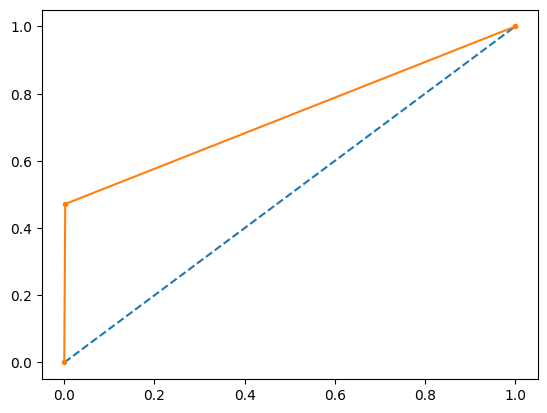

Confusion matrix, without normalization
[[11232    24]
 [  177   158]]


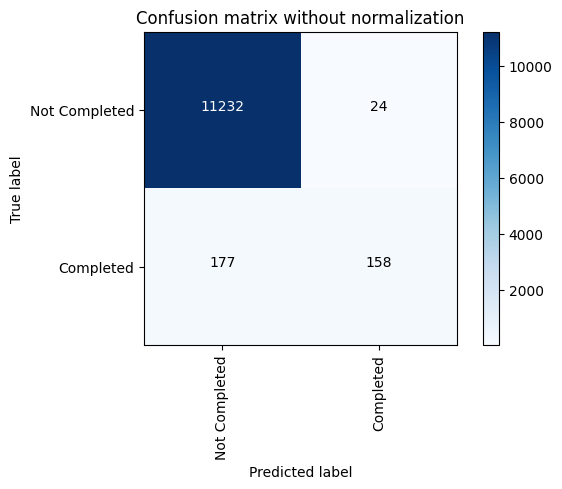

In [106]:


auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, predictions)


print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))
print("RMS Error {}".format(mean_squared_error(y_test, predictions, multioutput = 'uniform_average')))
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr,tpr, marker='.')
# show the plot
pyplot.show()

cnf_matrix=confusion_matrix(y_test,predictions)
plot_confusion_matrix(cnf_matrix,classes=all_classes, title='Confusion matrix without normalization')

AUC: 0.955
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     11255
           1       0.65      0.93      0.77       336

    accuracy                           0.98     11591
   macro avg       0.83      0.96      0.88     11591
weighted avg       0.99      0.98      0.98     11591

0.9836079717021827
RMS Error 0.01639202829781727


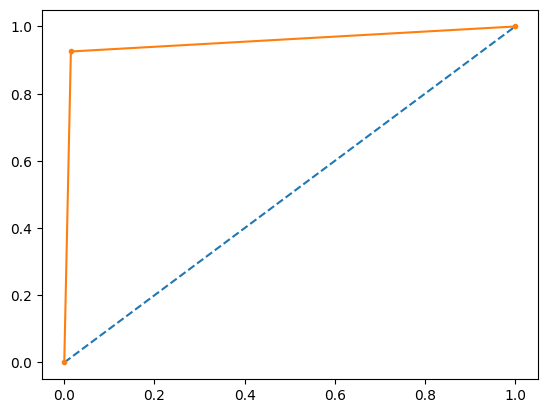

Confusion matrix, without normalization
[[11090   165]
 [   25   311]]


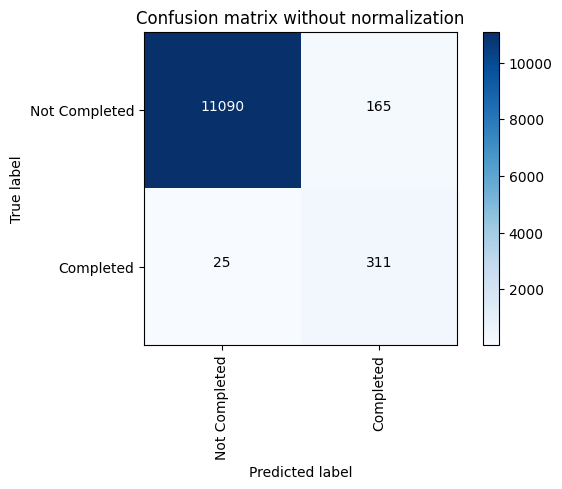

In [65]:
#Multi layer Perceptron

mlp = MLPClassifier(hidden_layer_sizes=(3, 15, 10), max_iter=1000)


mlp.fit(X_train, y_train.values.ravel())
predictions = mlp.predict(X_test)
auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, predictions)


print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))
print("RMS Error {}".format(mean_squared_error(y_test, predictions, multioutput = 'uniform_average')))
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr,tpr, marker='.')
# show the plot
pyplot.show()

cnf_matrix=confusion_matrix(y_test,predictions)
plot_confusion_matrix(cnf_matrix,classes=all_classes, title='Confusion matrix without normalization')

In [107]:
with open("MITx-SVC.pkl", "wb") as svcFile:
  pickle.dump(clf, svcFile)